In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = 'ibrahimelsayed25'
os.environ['KAGGLE_KEY'] = "01df320c0ba010cb1c6ff4314c310a57"

In [ ]:
! kaggle datasets download -d bulentsiyah/semantic-drone-dataset

100% 3.88G/3.89G [00:36<00:00, 82.0MB/s]
100% 3.89G/3.89G [00:36<00:00, 113MB/s] 


In [ ]:
! unzip semantic-drone-dataset.zip

In [ ]:
! pip install segmentation_models_pytorch

In [ ]:
import time 
import os
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio

from sklearn.model_selection import train_test_split

import torch 
import torch.nn as nn
from torch.utils.data  import Dataset, DataLoader
from torchvision import transforms as T
import torch.nn.functional as F

from PIL import Image
import cv2
import albumentations as A 

import segmentation_models_pytorch as smp
from os.path import isfile, join
from os import listdir

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
root_img_path = '/content/dataset/semantic_drone_dataset/original_images/'
root_mask_path = '/content/dataset/semantic_drone_dataset/label_images_semantic/'

In [ ]:
n_classes = 23

def get_image_id_df(root_img_path):
  name = []
  filenames = [f for f in listdir(root_img_path) if isfile(join(root_img_path,f))]
  for filename in filenames:
    name.append(filename.split(".")[0])
  return pd.DataFrame({"id": name}, index = np.arange(0,len(name)))

def pixel_accuracy(predicted_image, mask):
  '''  Pixel accuracy = Correctly predicted pixels divided by total number of pixels  '''
  with torch.no_grad():
    predicted_image = torch.argmax(F.softmax(predicted_image, dim=1), dim=1)
    correct = torch.eq(predicted_image,mask).int()
    accuracy = float(correct.sum()) / float(correct.numel())
  return accuracy

def mean_iou(predicted_label, label,  eps=1e-10, num_classes = 10):
  with torch.no_grad():
    predicted_label = F.softmax(predicted_label, dim=1)
    predicted_label = torch.argmax(predicted_label, dim = 1)

    predicted_label = predicted_label.contiguous().view(-1)
    label = label.contiguous().view(-1)

    iou_single_class = []
    for class_number in range(0, num_classes):
      true_predicted_class = predicted_label == class_number
      true_label = label == class_number

      if true_label.long().sum().item() == 0:
        iou_single_class.append(np.nan)
      else:
        intersection = (torch.logical_and(true_predicted_class, true_label).sum().float().item())
        union = (torch.logical_or(true_predicted_class, true_label).sum().float().item())
        iou = (intersection + eps) / (union + eps)
        iou_single_class.append(iou)
    return np.nanmean(iou_single_class)

def plot_loss_vs_epoch(history):
  plt.plot(history['val_loss'], label="val_loss", marker="o")
  plt.plot(history["train_loss"], label="train_loss", marker = "o")
  plt.title("Loss per epoch")
  plt.ylabel("Loss")
  plt.xlabel("Epochs")
  plt.legend(), plt.grid()
  plt.show()

def plot_iou_score_vs_epoch(history):
  plt.plot(history["train_miou"], label = "Train mIou", marker="*")
  plt.plot(history["val_miou"], label = "Val mIou", marker="*")
  plt.title("IoU Score per epoch")
  plt.ylabel("IoU Score")
  plt.xlabel("Epochs")
  plt.show()

def  plot_accuracy_vs_epoch(history):
  plt.plot(history["train_acc"], label="Train Accuracy", marker="*")
  plt.plot(history["val_acc"], label = "Val accuracy", marker="*")
  plt.title("Accuracy Per epoch")
  plt.ylabel("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()
  plt.show()


In [ ]:
image_list = os.listdir(root_img_path)
mask_list = os.listdir(root_mask_path)

image_list = [root_img_path+i for i in image_list]
mask_list = [root_mask_path+i for i in mask_list]

image_list = sorted(image_list)
mask_list = sorted(mask_list)


In [ ]:
print("Number of images are : ", len(image_list))
print(image_list[0])
print(mask_list[0])

Number of images are :  400
/content/dataset/semantic_drone_dataset/original_images/000.jpg
/content/dataset/semantic_drone_dataset/label_images_semantic/000.png


(4000, 6000, 3)
(4000, 6000)


Text(0.5, 1.0, 'Masked Image')

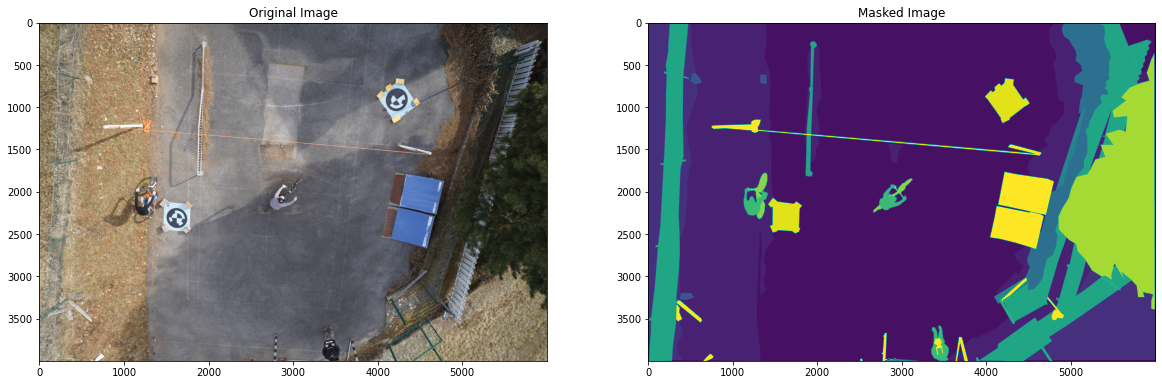

In [ ]:
## Show Image and its mask
idx = 10
img = imageio.imread(image_list[idx])
print(img.shape)
mask = imageio.imread(mask_list[idx])
print(mask.shape)
fig, arr = plt.subplots(1,2, figsize=(20,10))
arr[0].imshow(img)
arr[0].set_title('Original Image')
arr[1].imshow(mask)
arr[1].set_title('Masked Image')

## Data Preparation

In [ ]:
df = get_image_id_df(root_img_path)
df.head()

,id
0,251
1,233
2,460
3,190
4,235


In [ ]:
x_train_and_val, x_test = train_test_split(df["id"].values , test_size=0.1, random_state=19)
x_train, x_val = train_test_split(x_train_and_val, test_size = 0.15, random_state=19)

In [ ]:
print('Train Size', len(x_train))
print('Test size', len(x_test))
print('Val size', len(x_val))

Train Size 306
Test size 40
Val size 54


In [ ]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
model = smp.Unet( 'inceptionv4',encoder_weights = 'imagenet', classes=23, activation = None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/inceptionv4-8e4777a0.pth" to /root/.cache/torch/hub/checkpoints/inceptionv4-8e4777a0.pth


  0%|          | 0.00/163M [00:00<?, ?B/s]

## Data Generator

In [ ]:
class DataGen(Dataset):
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.mean = mean
        self.std = std
        self.transform = transform
        self.patches = patch

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path, self.X[idx] + ".jpg")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path, self.X[idx] + ".png" + cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug["image"])
            mask = aug["mask"]

        if self.transform is None:
            img = Image.fromarray(img)

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()

        if self.patches:
            img, mask = self.get_img_patches(img, mask)

    def get_img_patches(self, img, mask):
        """split images into patches fo size (512, 768)"""
        kh, kw = 512, 768  # kernel size
        dh, dw = 512, 768  # strides

        img_patches = img.unfold(1, kh, dh).unfold(2, kw, dw)

        img_patches = img_patches.contiguous().view(3, -1, kh, kw)

        img_patches = img_patches.permute(1, 0, 2, 3)

        # do the same for masks
        mask_patches = mask.unfold(0, kh, dh).unfold(1, kw, dw)
        mask_patches = mask_patches.contiguous().view(-1, kh, kw)

        return img_patches, mask_patches


In [ ]:
class TestDataGen(Dataset):
  def __init__(self, img_path, mask_path, x, transform=None):
    self.img_path = img_path
    self.mask_path = mask_path
    self.x = x
    self.transform = transform
  
  def __len__(self):
    return len(self.x)
  def __getitem__(self,idx):
    img = cv2.imread(self.img_path+self.x[idx] + ".jpg")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(self.mask_path+self.x[idx]+'.png', cv2.IMREAD_GRAYSCALE)
    if self.transform is not None:
      aug = self.transform(image=img, mask=mask)
      img = Image.fromarray(aug['image'])
      mask = aug['mask']

    if self.transform is None:
      img = Image.fromarray(img)
    mask = torch.from_numpy(mask).long()
    return img, mask

## Execute DataLoader

In [ ]:
mean = [0.485,0.456,0.406]
std = [0.229,0.224,0.225]
t_train = A.Compose([A.Resize(704,1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.GridDistortion(p=0.2)])
t_val = A.Compose([A.Resize(704,1056,interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.GridDistortion(p=0.2)])

# Bring DataGenerator
train_set = DataGen(root_img_path, root_mask_path, x_train, mean, std,t_train, patch=False)
val_set = DataGen(root_img_path, root_mask_path, x_val, mean, std, patch=False)
batch_size = 3
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)


## Training

In [ ]:
def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']


def train(epochs, model, train_loader, val_loader, criterion, optimizer, schudeuler, patch=False):
  torch.cuda.empty_cache()
  losses_train = []
  losses_test = []
  val_iou = []; val_acc=[];
  train_iou = []; train_acc=[]
  lrs = []
  min_loss =np.inf
  decreases = 1
  num_of_times_loss_not_improving = 0
  model.to(device)
  fit_time = time.time()
  for epoch in range(epochs):
    start_time= time.time()
    running_loss = 0
    iou_score= 0
    accuracy = 0
    model.train()
    for i, data in enumerate(tqdm(train_loader)):
      image_tiles, mask_tiles = data
      if patch:
        batch_size, n_tiles, channel, height, width = image_tiles.size()
        image_tiles = image_tiles.view(-1, channel, height, width)
        mask_tiles = mask_tiles.view(-1,channel, height, width)

      image = image_tiles.to(device)
      mask = mask_tiles.to(device)

      # Forward Propagation
      predicted_image = model(image)
      loss = criterion(predicted_image, mask)

      #Metric to do Evaluation
      iou_score += mean_iou(predicted_image, mask)
      accuracy += pixel_accuracy(predicted_image, mask)

      #Backward Propagation
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      lrs.append(get_lr(optimizer))
      schudeuler.step()
      running_loss += loss.item()

    else:
      model.eval()
      test_loss = 0
      test_accuracy = 0
      val_iou_score = 0

      with torch.no_grad():
          for i, data in enumerate(tqdm(val_loader)):
              image_tiles, mask_tiles = data

              if patch:
                  batch_size, n_tiles, channel, height, width = image_tiles.size()
                  image_tiles = image_tiles.view(-1, channel, height, width)
                  mask_tiles = mask_tiles.view(-1, height, width)

              image = image_tiles.to(device)
              mask = mask_tiles.to(device)

              # Forward Propagation
              predicted_image = model(image)

              # Metric to do Evaluation
              val_iou_score += mean_iou(predicted_image, mask)
              test_accuracy += pixel_accuracy(predicted_image, mask)

              loss = criterion(predicted_image, mask)
              test_loss += loss.item()

              # Mean IoU for each batch calculation
              losses_train.append(running_loss / len(train_loader))
              losses_test.append(test_loss / len(val_loader))

              # Checking for Loss Decreases
              if min_loss > (test_loss / len(val_loader)):
                  print(
                      "Loss Decreasing... {:.3f} >> {:.3f} ".format(
                          min_loss, (test_loss / len(val_loader))
                      )
                  )
                  min_loss = test_loss / len(val_loader)
                  decreases += 1
                  if decreases % 5 == 0:
                      print("Saving Model as loss is decreasing..")
                      torch.save(
                          model,
                          "Inception-v4_mIoU-{:.3f}.pt".format(
                              val_iou_score / len(val_loader)
                          ),
                      )

                  # If the Loss is NOT decreasing
                  if (test_loss / len(val_loader)) > min_loss:
                      min_loss = test_loss / len(val_loader)
                      print(
                          f"Loss Not Decreasing for {num_of_times_loss_not_improving} time"
                      )
                      if num_of_times_loss_not_improving == 6:
                          print(
                              "Loss not decreasing for 6 times, hence stopping Training"
                          )
                          break

              # Updating IoU and and Accuracy
              train_iou.append(iou_score / len(train_loader))
              train_acc.append(accuracy / len(train_loader))
              val_iou.append(val_iou_score / len(val_loader))
              val_acc.append(test_accuracy / len(val_loader))

              print(
                  "Epoch:{}/{}..".format(epoch + 1, epochs),
                  "Train Loss:{:.3f}..".format(running_loss / len(train_loader)),
                  "Validation Loss: {:.3f}..".format(test_loss / len(val_loader)),
                  "Train mean_iou:{:.3f}..".format(iou_score / len(train_loader)),
                  "Validation mean_iou: {:.3f}..".format(
                      val_iou_score / len(val_loader)
                  ),
                  "Train Acc:{:.3f}..".format(accuracy / len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy / len(val_loader)),
                  "Time: {:.2f}m".format((time.time() - start_time) / 60),
              )

    history = {
        "train_loss": losses_train,
        "val_loss": losses_test,
        "train_miou": train_iou,
        "val_iou": val_iou,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "lrs": lrs,
    }
    print("Total time: {:.2f} m".format((time.time() - fit_time) / 60))
    return history






## Execute Training

In [ ]:
max_lr = 1e-3
epochs = 15
weight_decay = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = max_lr, weight_decay=weight_decay)
schedular = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs = epochs, steps_per_epoch=len(train_loader))
history = train(epochs, model, train_loader, val_loader, criterion, optimizer, schedular)